In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, log_loss
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn.linear_model import LogisticRegression
import warnings
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np

from helper import plot_random_forest_accuracy, simple_feature_importance, compare_feature_importance, plot_partial_dependence, compare_gb_rf_log, gb_hyperparam_analysis, compare_gb_rf_linear

from sklearn.discriminant_analysis import StandardScaler

warnings.filterwarnings('ignore')

# Notes

<br><br>
# **Table of Contents**

- [Decision Trees](#decision-trees)
  - [Dataset Overview: Synthetic Heart Disease Prediction](#dataset-overview-synthetic-heart-disease-prediction)
  - [Interpreting the Decision Tree Results](#interpreting-the-decision-tree-results)
- [Random Forests](#random-forests)
  - [Interpreting Random Forest vs Single Tree Results](#interpreting-random-forest-vs-single-tree-results)
  - [How Random Forest Creates "Wisdom of Crowds"](#how-random-forest-creates-wisdom-of-crowds)
  - [Understanding Feature Importance Rankings](#understanding-feature-importance-rankings)
  - [Understanding Feature-Risk Relationships](#understanding-feature-risk-relationships)
  - [How Partial Dependence Plots Work](#how-partial-dependence-plots-work)
- [Gradient Boosting: Learning from Mistakes](#gradient-boosting-learning-from-mistakes)
- [Random Forest vs Gradient Boosting: Quick Comparison](#random-forest-vs-gradient-boosting-quick-comparison)

<br><br>
# **Hands-On: Decision Trees and Random Forest**

## Learning Goals
By the end of this session, you will be able to:

- **Build and interpret decision tree models**
  - Create decision trees for classification using synthetic heart disease data
  - Read decision tree visualizations and understand splitting criteria and decision paths

- **Implement ensemble methods for improved predictions**
  - Apply Random Forest to combine multiple decision trees and reduce overfitting
  - Compare single tree performance vs. ensemble "wisdom of crowds" approach

- **Analyze feature importance and relationships**
  - Extract and interpret feature importance rankings from Random Forest models
  - Use partial dependence plots to understand how individual features affect predictions

- **Apply gradient boosting for sequential learning**
  - Implement gradient boosting algorithms that learn from previous model mistakes
  - Compare Random Forest (parallel) vs. Gradient Boosting (sequential) ensemble strategies

<br><br>
# **Decision Trees**

Decision trees mirror how healthcare professionals naturally make clinical decisions - through a series of **if-then questions** based on patient characteristics, symptoms, and test results. Let's look at an example.

<br>

![Simple Decision Tree Example](imgs/simple_decision_tree.png)

<br>

**Why Decision Trees Excel in Healthcare:**
- **Interpretable**: Clinicians can follow the exact reasoning
- **Handle mixed data**: Works with categorical (symptoms) and numerical (lab values) features
- **No assumptions**: Doesn't require linear relationships or normal distributions
- **Missing data friendly**: Can handle incomplete patient records

## Dataset Overview: Synthetic Heart Disease Prediction

This dataset contains **1,000 patient records** with clinical features relevant to heart disease risk. Each row represents a patient, and each column is a clinical variable or the target diagnosis.

**Features:**

| Column             | Description                                              |
|--------------------|---------------------------------------------------------|
| `age`              | Patient age (years)                                     |
| `gender`           | 0 = Female, 1 = Male                                    |
| `chest_pain_type`  | 0 = Typical, 1 = Atypical, 2 = Non-cardiac, 3 = Asymptomatic |
| `blood_pressure`   | Systolic blood pressure (mmHg)                          |
| `cholesterol`      | Cholesterol level (mg/dl)                               |
| `blood_sugar_high` | Blood sugar > 120 mg/dl (0 = No, 1 = Yes)               |
| `ecg_results`      | 0 = Normal, 1 = Abnormal, 2 = Probable LVH              |
| `max_heart_rate`   | Maximum heart rate achieved                             |
| `exercise_angina`  | Exercise induced angina (0 = No, 1 = Yes)               |
| `heart_disease`    | Target: 0 = No disease, 1 = Disease present             |

- **Target variable:** `heart_disease` (binary classification)

This dataset is well-suited for exploring machine learning models for clinical risk prediction, feature importance, and model interpretability. Let's explore it first!

In [2]:
# Load the dataset
df = pd.read_csv('synthetic_heart_disease_prediction_dataset.csv')

In [3]:
# Display first few rows
df.head()

,age,gender,chest_pain_type,blood_pressure,cholesterol,blood_sugar_high,ecg_results,max_heart_rate,exercise_angina,heart_disease
0,62,1,0,118,191,1,1,158,0,1
1,53,1,0,134,290,0,2,143,1,1
2,65,0,0,154,257,0,2,146,0,0
3,78,0,1,120,229,0,0,120,1,1
4,51,1,3,92,199,1,0,190,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   age               1000 non-null   int64
 1   gender            1000 non-null   int64
 2   chest_pain_type   1000 non-null   int64
 3   blood_pressure    1000 non-null   int64
 4   cholesterol       1000 non-null   int64
 5   blood_sugar_high  1000 non-null   int64
 6   ecg_results       1000 non-null   int64
 7   max_heart_rate    1000 non-null   int64
 8   exercise_angina   1000 non-null   int64
 9   heart_disease     1000 non-null   int64
dtypes: int64(10)
memory usage: 78.3 KB


Now that we have explored the dataset, let's prepare it for fitting our first decision tree.

In [5]:
# Prepare data for modeling
X = df.drop('heart_disease', axis=1)
y = df['heart_disease']

We keep a test set on the side, to judge the accuracy of the decision tree on unseen data. Stratify helps us keeping the ratios of target values balanced in training and test set.

In [6]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y # 'Stratify' ensures balanced classes in train/test split
)

Now we're all set. Let's fit a Decision Tree on the data!

In [7]:
# Create an even simpler decision tree with minimal information
max_depth = None  # If you like you can adjust the maximal depth of the tree

tree = DecisionTreeClassifier(
    max_depth=max_depth,  # Max depth of the tree, None means no limit
    random_state=42
)

# Fit the minimal tree
tree.fit(X_train, y_train)

# Make predictions
y_pred_minimal = tree.predict(X_test)
accuracy_minimal = accuracy_score(y_test, y_pred_minimal)

print(f"Minimal Decision Tree Accuracy on testdata: {accuracy_minimal:.3f}")

Minimal Decision Tree Accuracy on testdata: 0.560


We achieve an accuracy of 56% on the test set. Not too bad for a start! Let's visualize the Tree now.

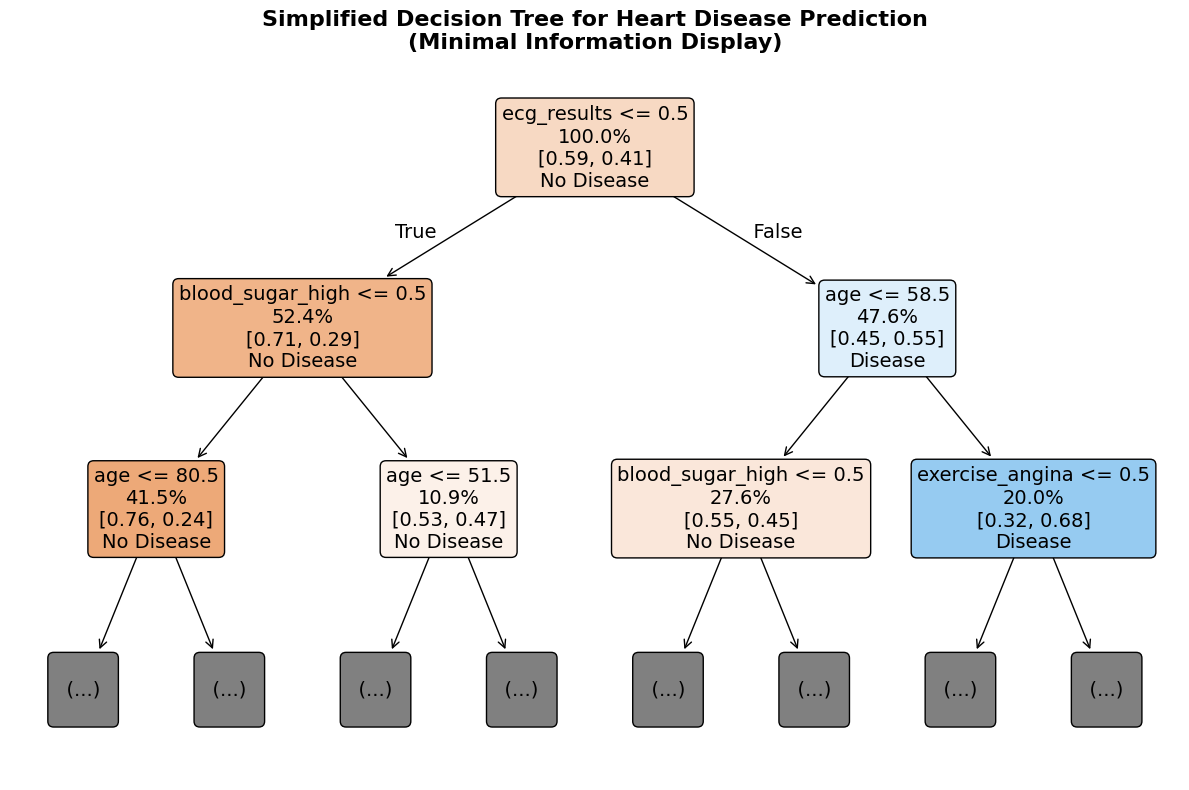

In [8]:
# Visualize the minimal decision tree with less information
plt.figure(figsize=(12, 8))
plot_tree(
    tree, 
    max_depth=2,  # Limit depth for clarity
    feature_names=X.columns,
    class_names=['No Disease', 'Disease'],
    label='none',
    filled=True,
    rounded=True,
    fontsize=14,
    # Reduce information shown
    proportion=True,  # Show proportions instead of raw counts
    impurity=False,   # Hide gini impurity values
    precision=2      # Limit decimal places
)
plt.title('Simplified Decision Tree for Heart Disease Prediction\n(Minimal Information Display)', 
          fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Interpreting the Decision Tree Results

### Key Decision Patterns:

Our heart disease prediction model follows this clinical logic:

1. **Primary split**: ECG results (most important predictor)
2. **Secondary factors**: Blood sugar levels and age (≤58.5 years)
3. **Final consideration**: Exercise-induced chest pain for older patients

The tree creates an intuitive medical decision pathway, prioritizing ECG abnormalities before considering metabolic factors and patient age.

To better understand which features drive the model's decisions, let's examine the calculated feature importance scores. **Feature importance** measures how much each variable contributes to reducing prediction uncertainty across all decision splits in the tree. Higher scores indicate features that create more "pure" splits, effectively separating patients with and without heart disease. 

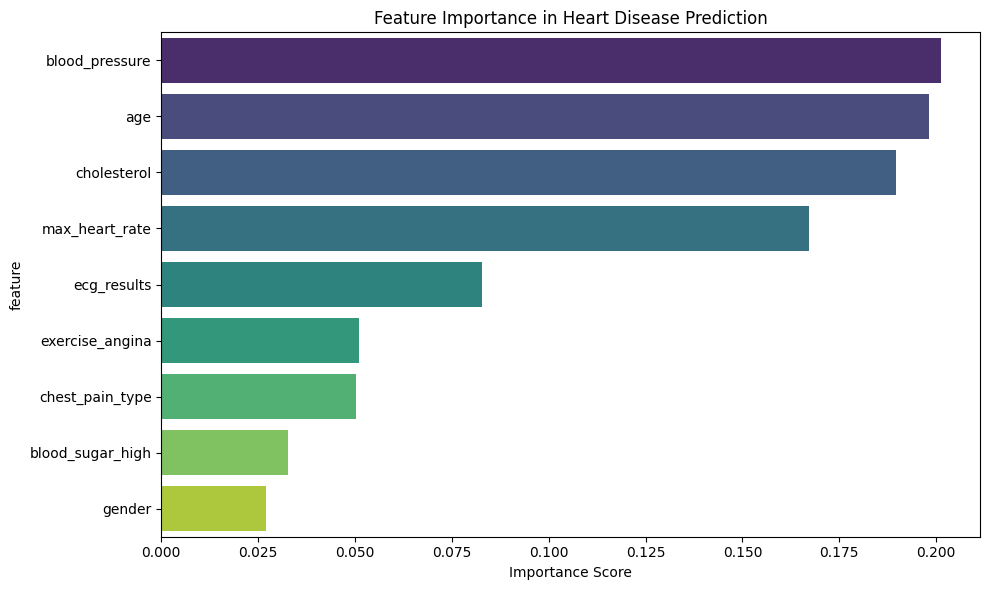

In [9]:
simple_feature_importance(X, tree)

### Feature Importance Analysis:

**Top Predictors:**
- **Blood pressure** (0.19): Dominates the model
- **Age** (0.19): Strong predictor reflecting age-disease relationship  
- **Cholesterol** (0.18): Key metabolic factor

**Limited Impact:**
- **Blood sugar, gender**: Low discriminative power

The rankings align with medical knowledge, prioritizing objective test results and demographics over traditional risk factors.

### Critical Limitations of Single Decision Trees:

- **Overfitting**: Trees memorize training data noise rather than learning generalizable patterns
- **Instability**: Small data changes create completely different tree structures  
- **Poor generalization**: Models trained on one dataset often fail on new, unseen data

Single trees are too simplistic for complex medical diagnosis and lack the robustness needed for reliable clinical decision-making.

**Random Forests** overcome these limitations by combining multiple diverse trees, creating robust and reliable predictions for clinical decision-making.

---
<br><br>
# **Random Forests** 

**From Single Trees to Ensemble Power:**
Decision trees are powerful and interpretable, but suffer from being too simplistic and generalizing poorly. The solution? **Ensemble methods** - combining many weak models to create strong predictions through averaging. When multiple decision trees work together, their individual biases cancel out, resulting in robust and accurate predictions.

Imagine asking **100 different doctors** to independently diagnose a patient, each using different patient samples and diagnostic tests, then combining all their opinions through **majority vote**. This is exactly how Random Forests work! 

**Random Forest = Bagging + Random Feature Selection**

Training Process:<br>
├── Tree 1: Random sample of patients + Random subset of features<br>
├── Tree 2: Different random sample + Different feature subset<br>
├── Tree 3: Different random sample + Different feature subset<br>
├── ...<br>
└── Tree N: Different random sample + Different feature subset<br>

The final Prediction is then made using Majority vote (when we try to predict a target label) or Averaging (when we predict continuous values). It's like a medical board where multiple specialists with different expertise reach better diagnoses together than any individual doctor alone.

**Two Key Randomness Sources:**

| Randomness Type | Description | Purpose |
|-----------------|-------------|---------|
| **Bootstrap Sampling (Bagging)** | Each tree trained on different random sample (~63% of data with replacement) | Reduces overfitting through diverse training sets |
| **Random Feature Selection** | Each split considers only random subset of features | Prevents dominant features from appearing in every tree, creates diverse decision patterns |

**Why Random Forests Excel in Healthcare:**

- **Robust Predictions**: Less sensitive to outliers or unusual patients
- **Feature Importance**: Identifies most predictive clinical variables
- **Reduced Overfitting**: Ensemble effect smooths out individual tree biases

Let's start by comparing the accuracy of fitting a Decision Tree and a Random Forest with 100 trees. Random Forest offers several hyperparameters we can tune to optimize performance, including the number of trees, maximum tree depth, and how many features to consider at each split - though we'll use default values for now to establish our baseline comparison.

In [10]:
# Single Decision Tree (from previous section)
single_tree = DecisionTreeClassifier(random_state=42)
single_tree.fit(X_train, y_train);

In [11]:
# Random Forest with tunable hyperparameters (all set to default values)
n_estimators = 100        # Number of trees in the forest

rf = RandomForestClassifier(
    n_estimators=n_estimators,      # Number of trees
    random_state=42,
)
rf.fit(X_train, y_train);

In [12]:
# Compare performance
single_tree_accuracy = single_tree.score(X_test, y_test)
rf_accuracy = rf.score(X_test, y_test)

print(f"Single Decision Tree Accuracy: {single_tree_accuracy:.4f}")
print(f"Random Forest Accuracy:        {rf_accuracy:.4f}")
print(f"Improvement:                   {rf_accuracy - single_tree_accuracy:.4f}")

Single Decision Tree Accuracy: 0.5600
Random Forest Accuracy:        0.7100
Improvement:                   0.1500


Random Forest achieved **71% accuracy** vs Single Tree's **56% accuracy** - a **15 percentage point gain**

- **Ensemble Effect**: 100 diverse trees compensate for individual weaknesses
- **Reduced Overfitting**: Bootstrap sampling and random features prevent memorizing noise

Improved accuracy comes at cost of reduced interpretability and increased computational complexity. Let's see if the performance is still good when we perform cross validation.

In [13]:
# Cross-validation comparison for more robust evaluation
cv_single = cross_val_score(single_tree, X_train, y_train, cv=5)
cv_rf = cross_val_score(rf, X_train, y_train, cv=5)

print(f"\nCross-Validation Results (5-fold):")
print(f"Single Tree: {cv_single.mean():.4f} ± {cv_single.std():.4f}")
print(f"Random Forest: {cv_rf.mean():.4f} ± {cv_rf.std():.4f}")


Cross-Validation Results (5-fold):
Single Tree: 0.5750 ± 0.0416
Random Forest: 0.6438 ± 0.0422


Random Forest achieved **64.4% ± 4.2%** vs Single Tree's **57.5% ± 4.2%** - a **7 percentage point improvement**

- **Consistent Advantage**: Forest outperforms across all 5 validation folds
- **Stable Performance**: Similar standard deviation shows ensemble doesn't increase variance
- **Robust Generalization**: Performance gain holds when tested on completely unseen data

The cross-validation results validate that Random Forest's superior accuracy isn't due to overfitting to our specific test set, but represents genuine improvement in predictive capability.

Random Forests provide another unique advantage: **built-in performance estimation** without needing a separate validation set. Since each tree uses only a subset of the training data (bootstrap sampling), the remaining data serves as a natural test set for that tree, allowing us to calculate an unbiased performance estimate called the **Out-of-Bag score**.

In [14]:
# Create a Random Forest and examine its components
rf_detailed = RandomForestClassifier(
    n_estimators=100,  # Fewer trees for detailed analysis
    random_state=42,
    oob_score=True    # Calculate out-of-bag error
)

rf_detailed.fit(X_train, y_train)

print(f"  Number of trees: {rf_detailed.n_estimators}")
print(f"  Out-of-bag score: {rf_detailed.oob_score_:.4f}")

  Number of trees: 100
  Out-of-bag score: 0.6488


**OOB Score: 64.9%** - This closely matches our cross-validation result (64.4%), confirming the model's reliability and demonstrating that OOB provides an accurate performance estimate without additional computational cost.

Now let's examine how the number of trees affects ensemble performance and whether more trees always lead to better predictions:

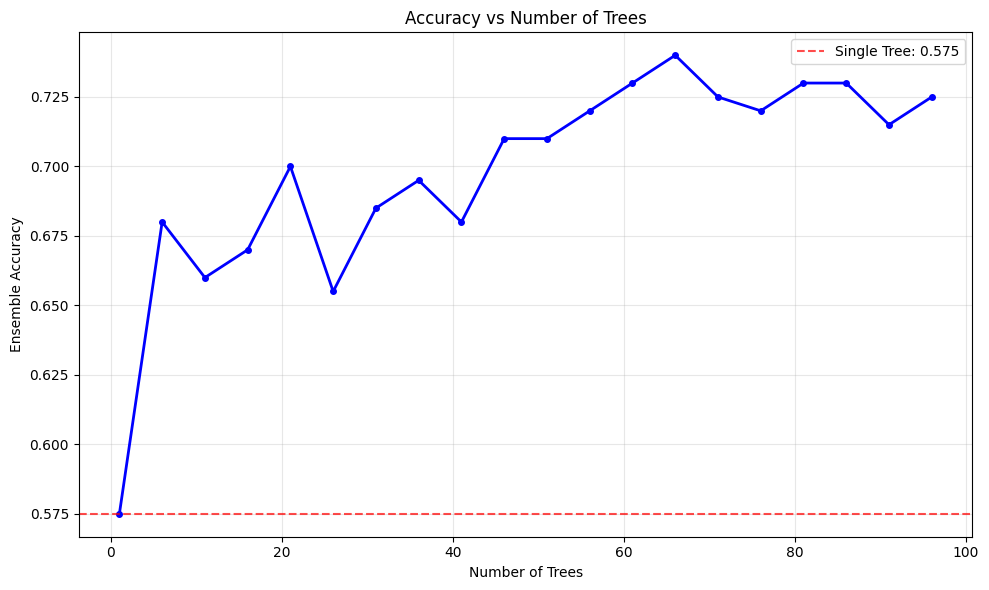

In [15]:
plot_random_forest_accuracy(X_train, y_train, X_test, y_test, max_trees=100)

- **Rapid Initial Improvement**: Performance jumps dramatically from 1 to ~10 trees, showing immediate ensemble benefits
- **Plateau Effect**: Beyond 40-50 trees, accuracy stabilizes around 72-73% with diminishing returns
- **Optimal Range**: 60-80 trees appears to be the sweet spot, balancing performance and computational efficiency
- **No Overfitting**: Unlike individual models, adding more trees doesn't degrade performance - the ensemble remains robust

While 100+ trees won't hurt performance, 50-80 trees typically provide the best cost-benefit ratio for most applications.

Now that we've optimized our Random Forest, let's investigate which clinical features are most influential in predicting heart disease risk.

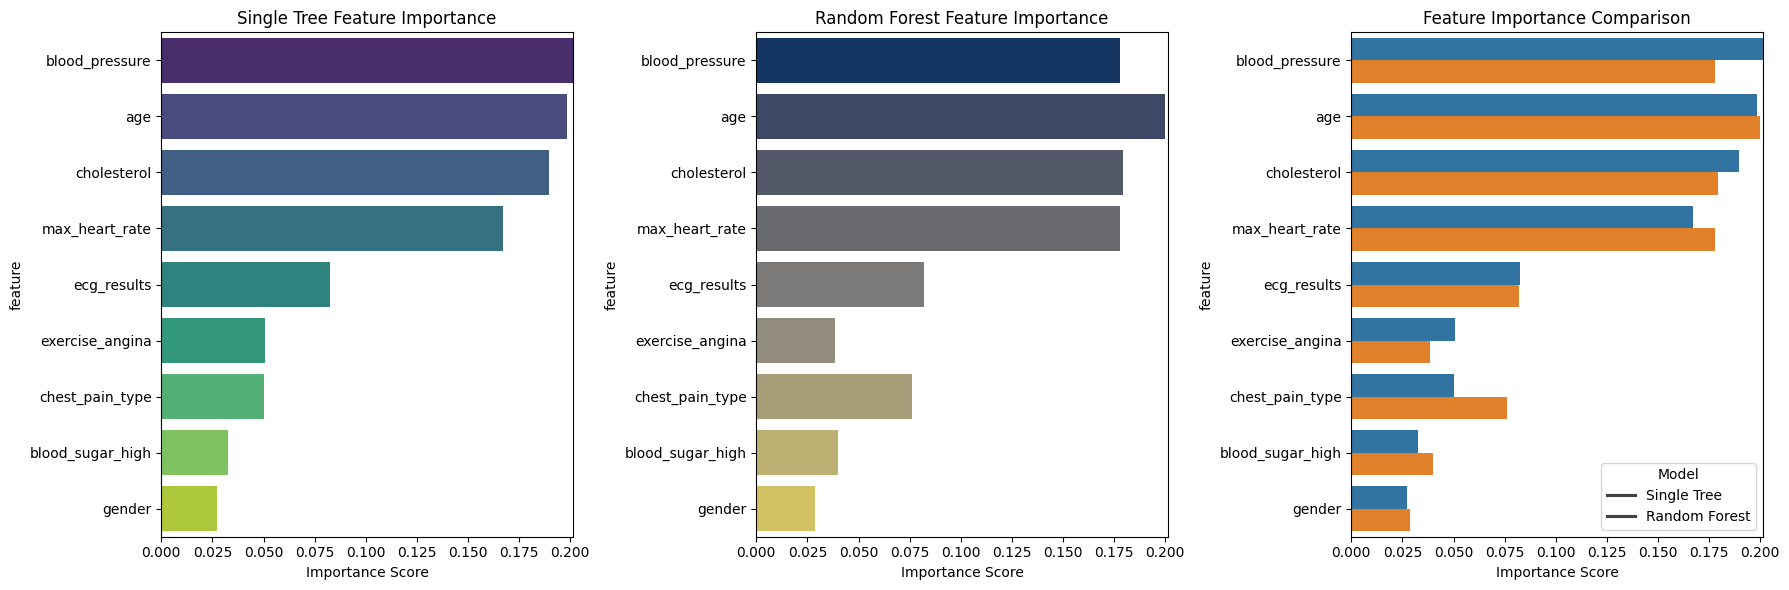

In [16]:
compare_feature_importance(X, single_tree, "Single Tree", rf, "Random Forest")

Feature importance scores represent the relative contribution of each variable to reducing prediction uncertainty across all trees, with higher scores indicating greater predictive power.

**Random Forest Rankings (Left Plot):**
- **Age** dominates as the strongest predictor (0.20)
- **Cardiovascular cluster**: Cholesterol, blood pressure, and max heart rate form the core diagnostic features
- **Gender and blood sugar** show limited discriminative power for heart disease prediction

**Single Tree vs Random Forest Comparison (Right Plot):**
- **Similar overall patterns**: Both models assign comparable importance scores to most features

While feature importance tells us *which* variables matter most, let's explore *how* these key features actually influence heart disease predictions through partial dependence plots. **Partial dependence plots show the average effect of a single feature on predictions while holding all other features constant**, revealing whether the relationship is linear, non-linear, or has thresholds that dramatically change risk assessment. This is a key feature for interpretability.

Analyzing partial dependence for: ['age', 'cholesterol', 'blood_pressure', 'max_heart_rate']


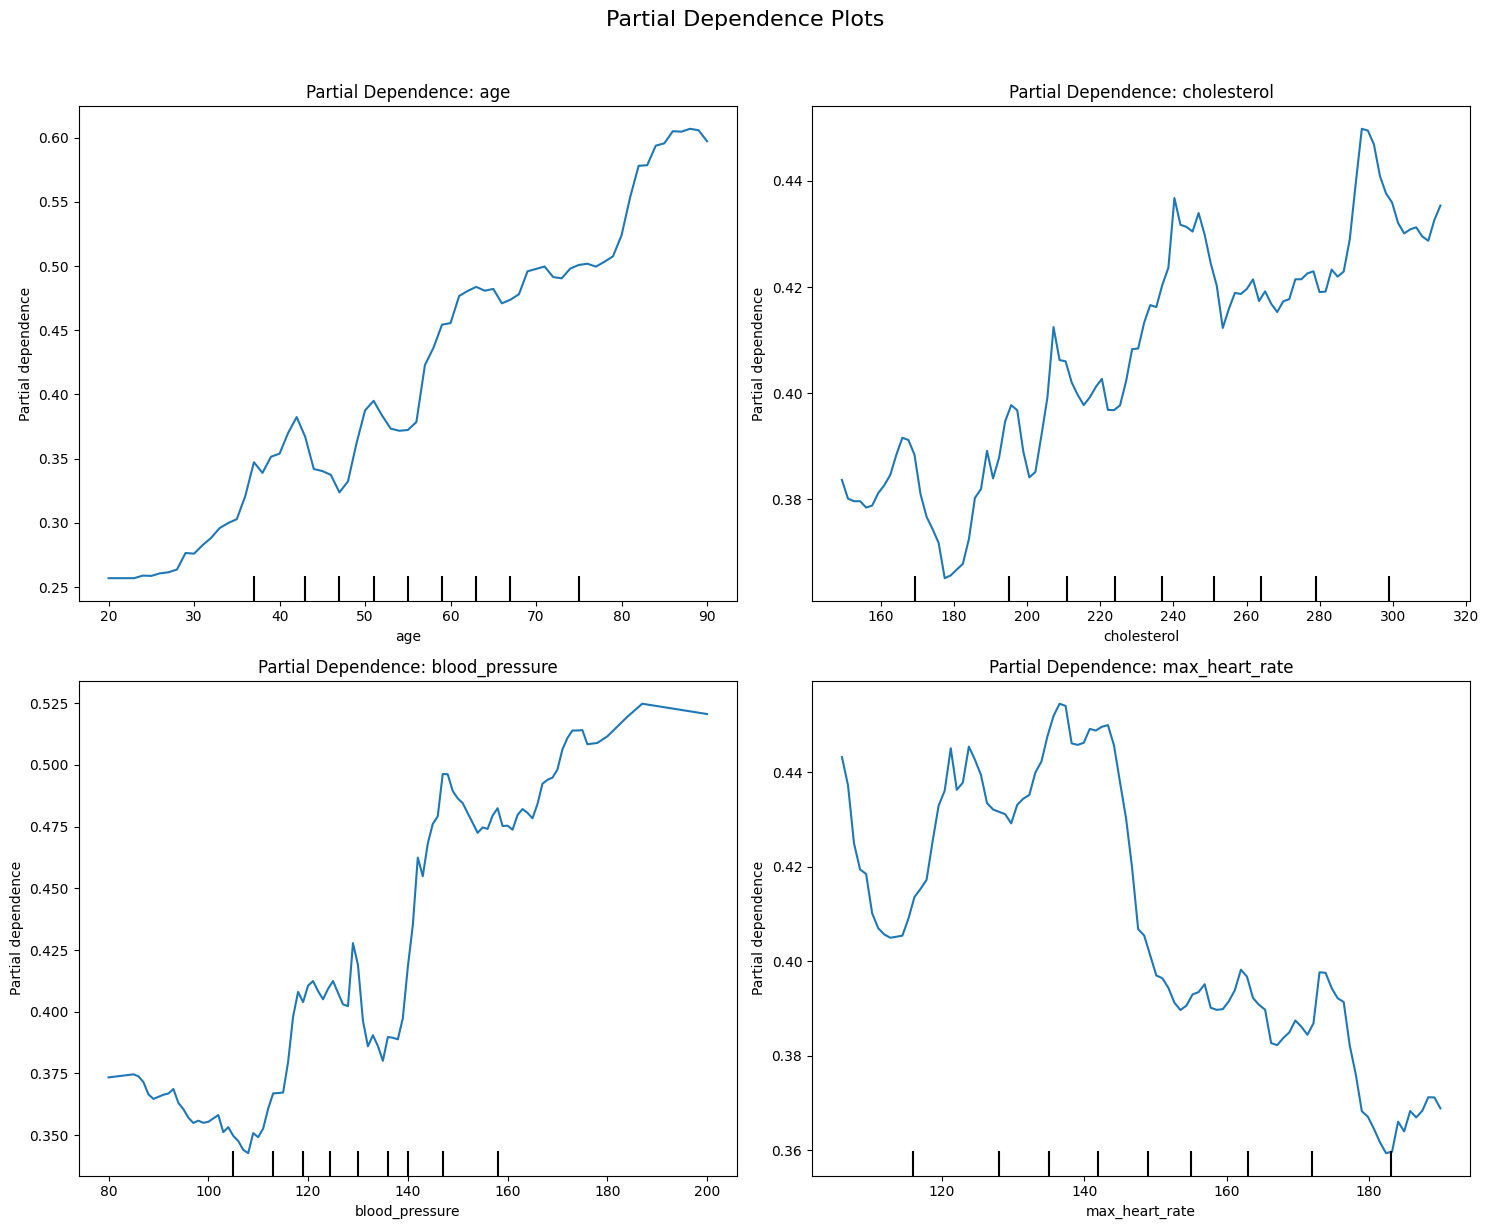

In [17]:
plot_partial_dependence(X_train, rf, n_features=4)

**Partial Dependence Plot Insights:**

- **Age**: Clear upward trend showing heart disease risk increases substantially after age 50, with steepest climb between 50-80 years
- **Cholesterol**: Complex non-linear relationship with elevated risk at very high levels (280+ mg/dL) and some intermediate spikes
- **Blood Pressure**: Sharp risk increase around 140 mmHg (hypertension threshold), then plateaus at higher levels
- **Max Heart Rate**: Inverted U-shape with peak risk around 140-150 bpm, suggesting both very low and very high rates indicate problems

These patterns help identify optimal intervention thresholds and patient risk stratification for targeted preventive care.

Finally we will look at one more modelling technique.

---
<br><br>
# **Gradient Boosting: Learning from Mistakes**

Imagine a **medical student learning diagnosis**:
1. **First attempt**: Makes basic predictions, gets some wrong
2. **Learns from errors**: Focuses on the cases they misdiagnosed
3. **Second attempt**: Corrects previous mistakes, but makes new ones
4. **Iterative improvement**: Each attempt focuses on remaining errors
5. **Final expertise**: Combines all learned corrections into expert-level diagnosis

This is exactly how **Gradient Boosting** works!

### **Step-by-Step Process:**

**1. Initialize with a Simple Prediction**

Initial prediction = average of all target values

**2. For each iteration (tree):**

1. Calculate residuals (errors) = actual - predicted
2. Train new tree to predict these residuals
3. Add tree's predictions to ensemble (with learning rate)
4. Update overall predictions

**Core Concept: Sequential Error Correction**

Boosting Process:<br>
├── Tree 1: Learn basic patterns → Residual errors<br>
├── Tree 2: Learn from Tree 1's errors → New residual errors<br>
├── Tree 3: Learn from remaining errors → Smaller residuals<br>
├── ...<br>
└── Tree N: Final error corrections<br>

Final Prediction = Tree1 + Tree2 + Tree3 + ... + TreeN

**Key Advantages:**
- **High Accuracy**: Often achieves state-of-the-art performance
- **Handles Complex Patterns**: Excellent at capturing non-linear relationships
- **Feature Selection**: Automatically focuses on most informative features
- **Interpretable**: Can analyze which cases are hardest to predict

**Let's see this sequential learning in action with real medical data:**

In [18]:
gb = GradientBoostingClassifier(
    n_estimators=100,  # Number of boosting stages to be run
    random_state=42)
gb.fit(X_train, y_train);

In [19]:
# Predict and evaluate
y_pred_gb = gb.predict(X_test)
gb_accuracy = accuracy_score(y_test, y_pred_gb)
print(f"Gradient Boosting Classifier Accuracy: {gb_accuracy:.4f}")

Gradient Boosting Classifier Accuracy: 0.7100


In [20]:
# Cross-validation for Gradient Boosting
cv_gb = cross_val_score(gb, X_train, y_train, cv=5)
print(f"Gradient Boosting Cross-Validation Accuracy: {cv_gb.mean():.4f} ± {cv_gb.std():.4f}")

Gradient Boosting Cross-Validation Accuracy: 0.6613 ± 0.0406


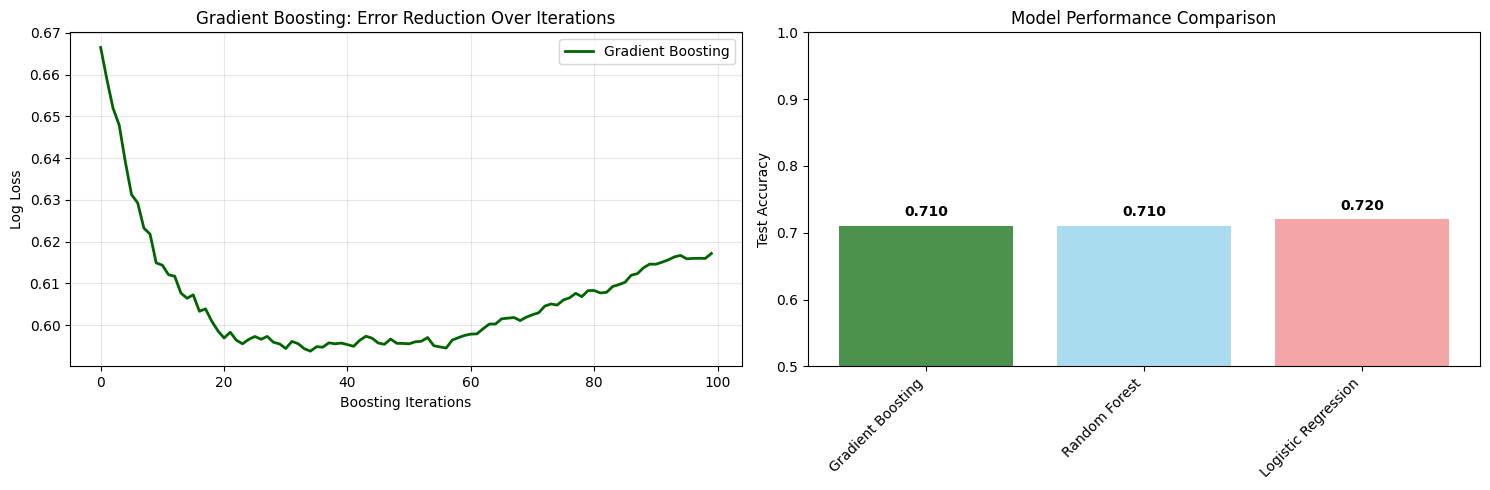

In [21]:
# TODO: maybe even remove this part
_ = compare_gb_rf_log(X_train, y_train, X_test, y_test)

- **Left Plot**: Error reduction follows the expected pattern - steep initial improvement, then gradual convergence, until we start overadjusting
- **Right Plot**: All three models achieve similar accuracy (~71%), showing that simpler methods can be competitive

Now let's examine how playing with hyperparameters such as the number of trees, learning rate and maximal depths of the trees affects Gradient Boosting performance:

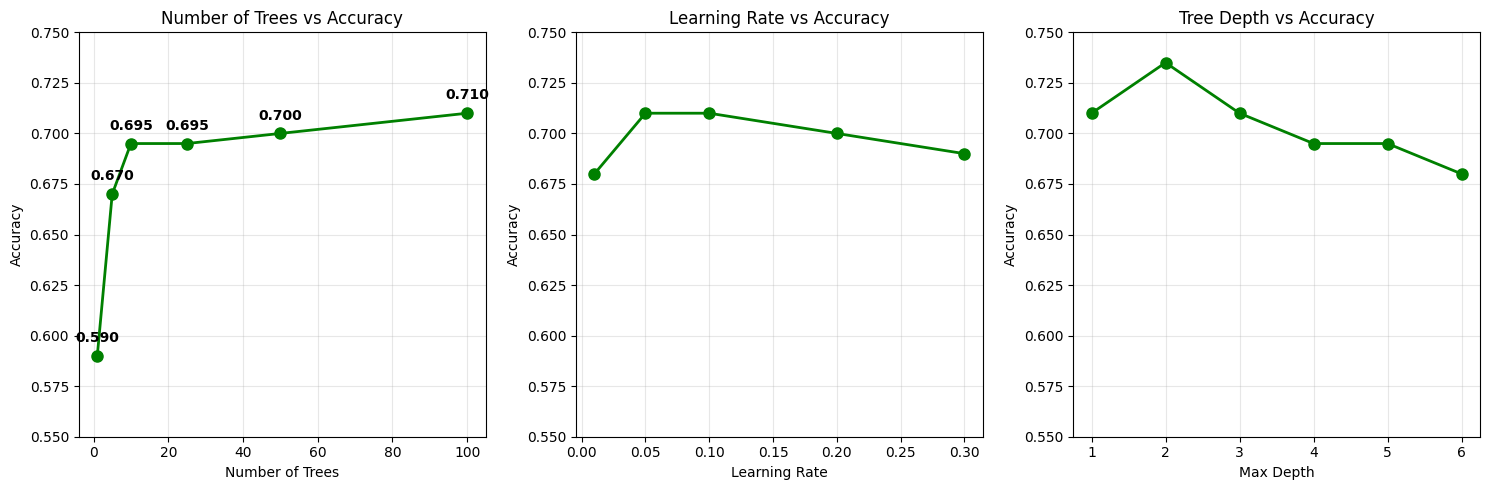

In [22]:
# Hyperparameter Analysis for Gradient Boosting
gb_hyperparam_analysis(X_train, y_train, X_test, y_test)

- **Number of Trees**: Rapid improvement from 1→5 trees, then gradual gains up to 100 trees
- **Learning Rate**: Sweet spot around 0.05-0.1; too low (0.01) underperforms, too high (0.3) causes instability
- **Tree Depth**: Optimal at depth 2; deeper trees lead to overfitting and reduced performance

Gradient Boosting benefits from many shallow trees with moderate learning rates.

Now let's examine which medical features these models consider most important for stroke prediction:

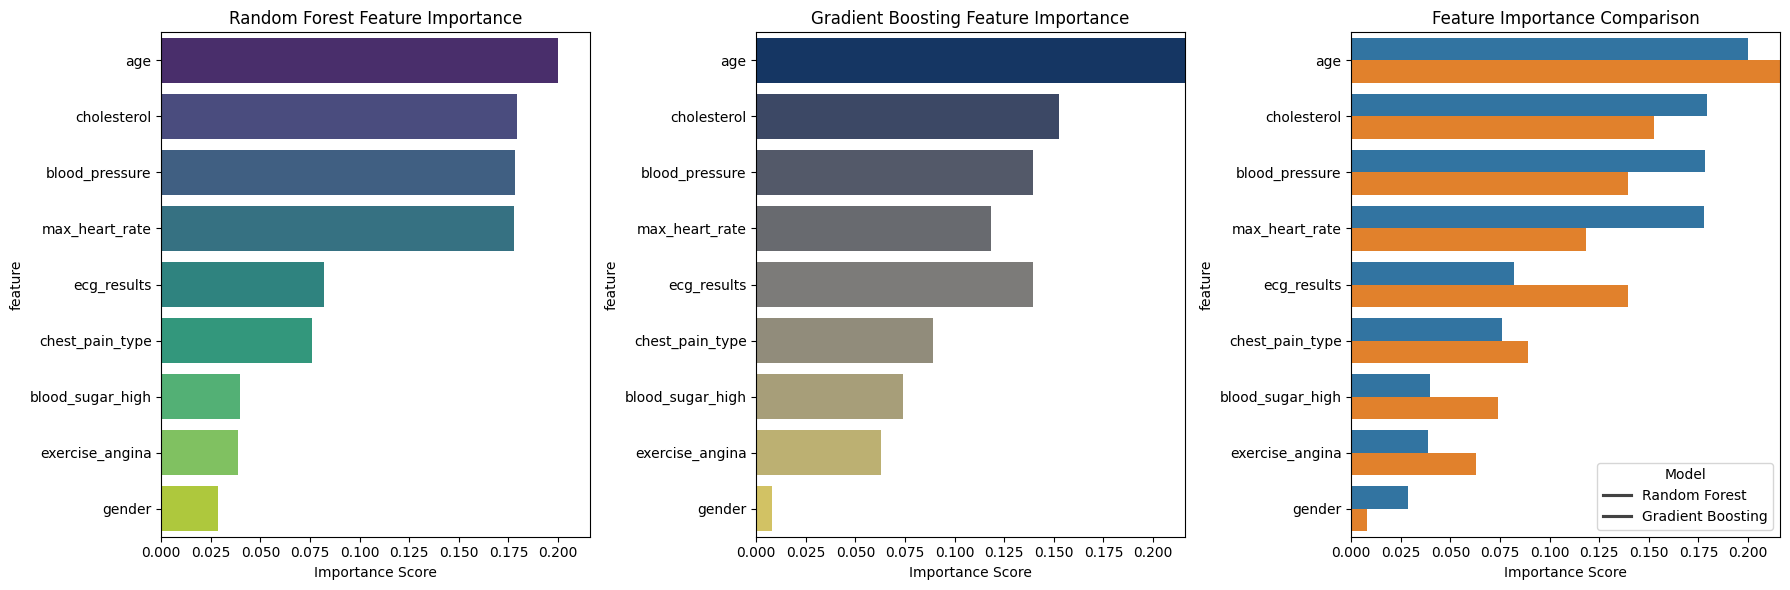

In [23]:
compare_feature_importance(X, rf, 'Random Forest', gb, 'Gradient Boosting')

- **Strong Agreement**: Both models identify **age** and **cholesterol** as the top predictors
- **Key Differences**: Gradient Boosting emphasizes **ECG results** more, while Random Forest gives equal weight to **blood pressure** and **heart rate**
- **Clinical Relevance**: Age remains the dominant risk factor, followed by cardiovascular indicators

---
<br><br>
# **Application on Continuous Data**

Up to now we only used Random Forest and Gradient Boosting for **classification tasks**, predicting categorical outcomes like heart disease/no heart disease. However, these ensemble methods are highly flexible and can also tackle **regression problems** to predict continuous values.

Let's demonstrate this flexibility with a practical example.

## Dataset Overview: Cardiovascular Risk Assessment

This dataset contains **1,000 patient records** with clinical and lifestyle features relevant to cardiovascular health. Each row represents a patient, and each column is a clinical variable or lifestyle factor that contributes to their overall cardiovascular risk.

**Features:**

| Column               | Description                                              |
|----------------------|---------------------------------------------------------|
| `age`                | Patient age in years (20-80)                           |
| `bmi`                | Body Mass Index (18-40)                                |
| `systolic_bp`        | Systolic blood pressure in mmHg (90-180)               |
| `exercise_hours`     | Hours of exercise per week (0-15)                      |
| `sleep_hours`        | Hours of sleep per night (4-10)                        |
| `cardiovascular_risk`| **Target:** Risk score from 0-100 (higher = more risk) |

- **Target variable:** `cardiovascular_risk` (continuous regression)
- **Task:** Predict cardiovascular risk score based on patient characteristics

This dataset is perfect for exploring **regression** with ensemble methods, analyzing feature importance for risk factors, and understanding how lifestyle choices impact cardiovascular health. Let's dive in!

In [24]:
df = pd.read_csv('cardiovascular_risk_prediction.csv')

In [25]:
# display first few rows
df.head()

,age,bmi,systolic_bp,exercise_hours,sleep_hours,cardiovascular_risk
0,57.450712,30.597422,116.496435,5.123472,7.717275,49.449826
1,47.926035,28.698535,127.109627,12.325429,9.063934,32.106839
2,59.715328,25.238521,114.151602,0.901981,8.203399,46.733557
3,72.845448,22.412253,123.840769,10.492163,7.005103,31.719567
4,46.487699,27.792893,92.127707,1.692858,7.808639,46.125839


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1000 non-null   float64
 1   bmi                  1000 non-null   float64
 2   systolic_bp          1000 non-null   float64
 3   exercise_hours       1000 non-null   float64
 4   sleep_hours          1000 non-null   float64
 5   cardiovascular_risk  1000 non-null   float64
dtypes: float64(6)
memory usage: 47.0 KB


In [27]:
# Prepare features and target
X = df[['age', 'bmi', 'systolic_bp', 'exercise_hours', 'sleep_hours']]
y = df['cardiovascular_risk']

In [28]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Before we compare the models on the regression task, let's first show how to use the `RandomForestRegressor` and `GradientBoostingRegressor` from `sklearn` to fit the data.

In [29]:
# Random Forest Regressor
rf_regressor = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)
rf_regressor.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_regressor.predict(X_test)
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

In [30]:
# Gradient Boosting Regressor
gb_regressor = GradientBoostingRegressor(
    n_estimators=100,
    random_state=42
)
gb_regressor.fit(X_train, y_train)

# Predict and evaluate
y_pred_gb = gb_regressor.predict(X_test)
gb_mse = mean_squared_error(y_test, y_pred_gb)
gb_r2 = r2_score(y_test, y_pred_gb)


In [31]:
# Compare the two models
print(f"Random Forest Regressor - MSE: {rf_mse:.4f}, R²: {rf_r2:.4f}")
print(f"Gradient Boosting Regressor - MSE: {gb_mse:.4f}, R²: {gb_r2:.4f}")

Random Forest Regressor - MSE: 29.6954, R²: 0.8667
Gradient Boosting Regressor - MSE: 26.3116, R²: 0.8819


Now let's apply our ensemble methods to this regression task. We'll compare Random Forest and Gradient Boosting against a simple Linear Regression baseline to see how well each approach can predict cardiovascular risk scores. Let's evaluate their performance using cross-validation.

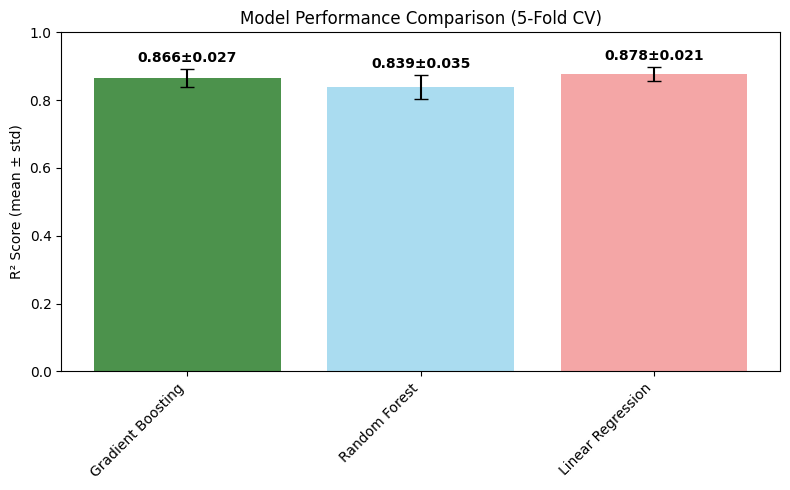

In [32]:
_ = compare_gb_rf_linear(X_train, y_train, X_test, y_test)

Applying these tools to regression tasks is exactly the same as classification - we simply switch from *Classifier* to *Regressor* classes, making it really easy to adapt these powerful methods to continuous prediction problems. Notice however, that for these simple dataset's the benefits often don't shine through, since a simple Linear Regression already performs reasonably well.

Now let's explore **which features** each model considers most important for predicting cardiovascular risk.

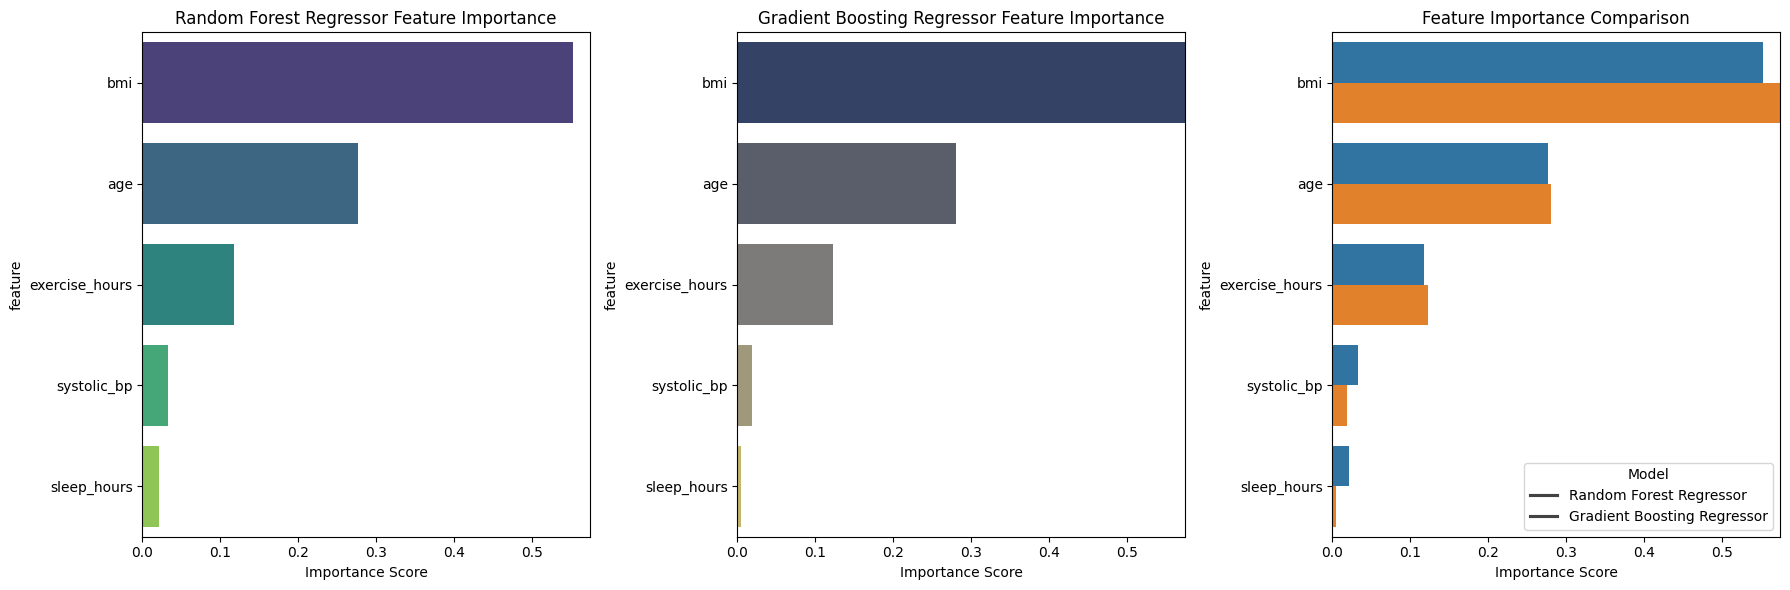

In [33]:
compare_feature_importance(X, rf_regressor, 'Random Forest Regressor', gb_regressor, 'Gradient Boosting Regressor')

Both models agree that **BMI** and **age** are the most important predictors of cardiovascular risk. Feature importance helps us understand **which** variables matter most, but it doesn't tell us **how** they affect the predictions.

To gain deeper insight into the relationships, let's examine **partial dependence plots** that show exactly how changes in age and BMI influence the predicted cardiovascular risk scores.

Analyzing partial dependence for: ['bmi', 'age']


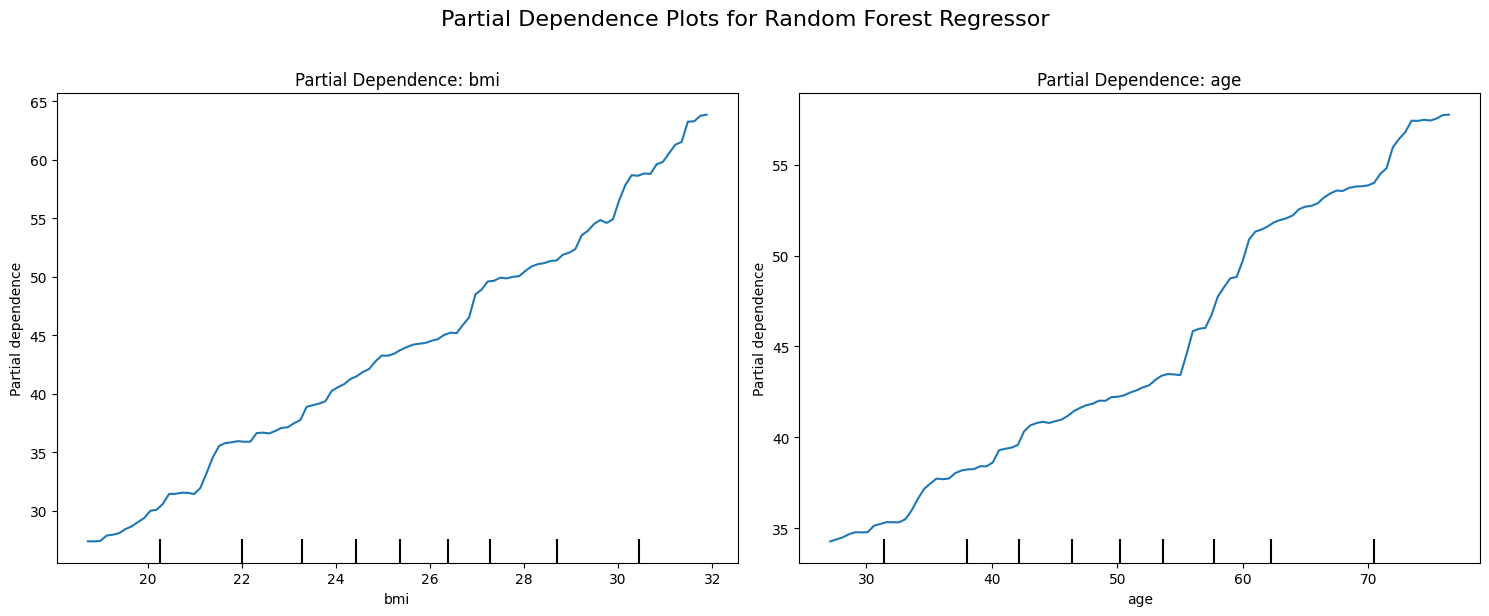

In [34]:
plot_partial_dependence(X_train, rf_regressor, n_features=2, title='Partial Dependence Plots for Random Forest Regressor')

Analyzing partial dependence for: ['bmi', 'age']


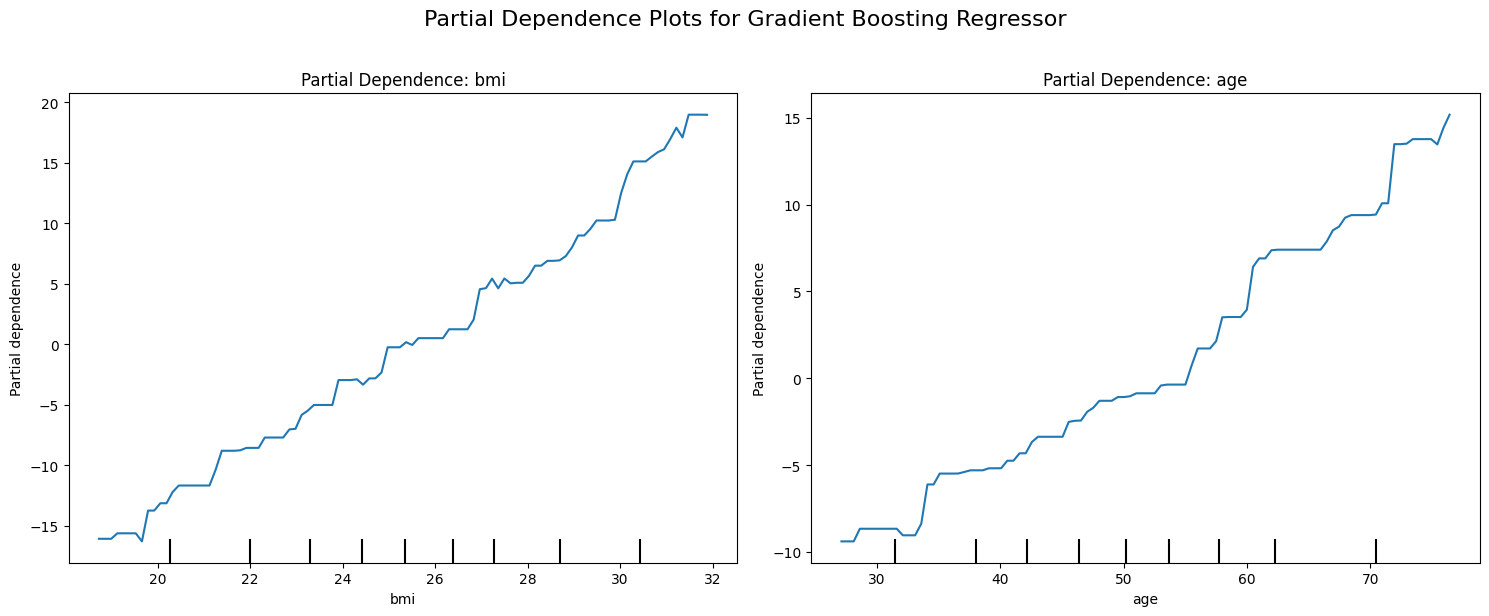

In [35]:
plot_partial_dependence(X_train, gb_regressor, n_features=2, title='Partial Dependence Plots for Gradient Boosting Regressor')

The partial dependence plots reveal how each model learned the underlying relationships. Both models show that **more exercise hours strongly reduce cardiovascular risk**, while **higher BMI increases risk**.

**Let's wrap it up by comparing Random Forest and Gradient Boosting overall:**

# **Random Forest vs Gradient Boosting**

| **Aspect** | **Random Forest** | **Gradient Boosting** |
|------------|-------------------|----------------------|
| **Ease of Use** | Works out-of-the-box | Requires careful tuning |
| **Training Speed** | Fast (parallel) | Slower (sequential) |
| **Accuracy** | Good baseline | Highest performance |
| **Overfitting Risk** | Built-in protection | More prone to overfit |
| **Complex Patterns** | Limited | Excellent |
| **Robustness** | Handles outliers well | Sensitive to outliers |

### **Clinical Decision Guide**
- **Random Forest**: Quick baselines, interpretability needs, limited tuning time
- **Gradient Boosting**: Maximum accuracy, complex patterns, tuning expertise available
- **Best Practice**: Start with Random Forest → upgrade to Gradient Boosting for production

---